In [1]:
# import libraries
from collections import Counter

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Library to make wordclouds
from wordcloud import WordCloud

# Natural language toolkit, the most popular library for NLP
import nltk
from nltk.tokenize import word_tokenize

# Scikit-learn: all you need for machine learning
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim library for representing documents as semantic vectors
from gensim.models import KeyedVectors
import gensim.downloader as api

# Command to show figures in a notebook
%matplotlib inline

In [133]:
# download package necessary for nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/roozendaal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Collection

In [134]:
# Load in dataset
# Category is the label of the email (spam or ham)

data = pd.read_csv('spam.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Preparation

In [135]:
example = 'This is an example sentence, with some punctuation,.!     characters &* and smileys :)'

In [136]:
# split sentence on whitespace, keeping all punctuation as part of a word
example.split()

['This',
 'is',
 'an',
 'example',
 'sentence,',
 'with',
 'some',
 'punctuation,.!',
 'characters',
 '&*',
 'and',
 'smileys',
 ':)']

In [137]:
# split on words and punctuation with word tokenizer from the nltk package
word_tokenize(example)

['This',
 'is',
 'an',
 'example',
 'sentence',
 ',',
 'with',
 'some',
 'punctuation',
 ',',
 '.',
 '!',
 'characters',
 '&',
 '*',
 'and',
 'smileys',
 ':',
 ')']

In [138]:
# Lowercase all words
data['Message'] = data['Message'].str.lower()

In [139]:
# Tokenize all sentences
data['tokens'] = data['Message'].apply(word_tokenize)

In [140]:
def remove_tokens(tokens, tokens_to_remove):
    return [word for word in tokens if word not in tokens_to_remove]

In [141]:
# Remove stopwords
stopwords = ['the', 'a', 'an', 'is']
data['cleaned_tokens'] = data['tokens'].apply(remove_tokens, args=(stopwords,))

In [142]:
# Remove punctuation
punctuation = [',', '.', ':']
data['cleaned_tokens'] = data['tokens'].apply(remove_tokens, args=(punctuation,))

In [143]:
# Stemming
# There are 2 different stemmers, play around to see the difference!
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

In [144]:
porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()

In [145]:
def stem_tokens(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

In [146]:
examples = ['connect', 'connection', 'connections', 'connected', 'connecting', 'connectiion']

print('porter stemmer: ', stem_tokens(examples, porter_stemmer))
print('lancaster stemmer: ', stem_tokens(examples, lancaster_stemmer))

porter stemmer:  ['connect', 'connect', 'connect', 'connect', 'connect', 'connectiion']
lancaster stemmer:  ['connect', 'connect', 'connect', 'connect', 'connect', 'connecty']


In [147]:
data['stemmed_tokens'] = data['cleaned_tokens'].apply(stem_tokens, args=(porter_stemmer,))

In [148]:
data.head(2)

,Category,Message,tokens,cleaned_tokens,stemmed_tokens
0,ham,"go until jurong point, crazy.. available only ...","[go, until, jurong, point, ,, crazy, .., avail...","[go, until, jurong, point, crazy, .., availabl...","[go, until, jurong, point, crazi, .., avail, o..."
1,ham,ok lar... joking wif u oni...,"[ok, lar, ..., joking, wif, u, oni, ...]","[ok, lar, ..., joking, wif, u, oni, ...]","[ok, lar, ..., joke, wif, u, oni, ...]"


# Data Exploration

In [149]:
# Count the number of ham / spam in the Category column
data.groupby('Category').count()

,Message,tokens,cleaned_tokens,stemmed_tokens
Category,,,,
ham,4825,4825,4825,4825
spam,747,747,747,747


In [152]:
# Are there any empty messages?
data[data['stemmed_tokens'].str.len() == 0]

,Category,Message,tokens,cleaned_tokens,stemmed_tokens


In [158]:
# print some random messages to check the labels
for i, row in data.sample(5, random_state=4).iterrows():
    print(row['Category'])
    print(row['Message'])
    print()

ham
somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true... goodnite &amp; sweet dreams

ham
is that on the telly? no its brdget jones!

ham
ok

spam
bloomberg -message center +447797706009 why wait? apply for your future http://careers. bloomberg.com

ham
what is the plural of the noun research?



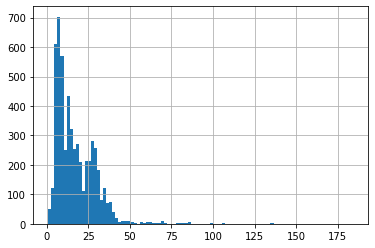

In [100]:
# Distribution of the nr of words per sentence
data['stemmed_tokens'].str.len().hist(bins=100);

In [101]:
# Make separate variables for spam and ham categories
ham = data[data['Category'] == 'ham']
spam = data[data['Category'] == 'spam']

In [102]:
# Store all tokens for category ham in one long list, 
# "explode" is a very handy buildin function for that (explode a list of lists)
ham_tokens = ham.explode('stemmed_tokens')['stemmed_tokens']
# Count the frequencies per word
ham_tokens.value_counts()[:10]

i      2880
you    1939
to     1562
?      1375
...    1139
the    1131
a      1064
u       994
it      924
and     856
Name: stemmed_tokens, dtype: int64

In [103]:
# Store all tokens for category spam in one list
spam_tokens = spam.explode('stemmed_tokens')['stemmed_tokens']
# Count the frequencies per word
spam_tokens.value_counts()[:10]

to      687
!       546
a       377
call    362
you     297
your    278
free    219
for     203
the     203
now     199
Name: stemmed_tokens, dtype: int64

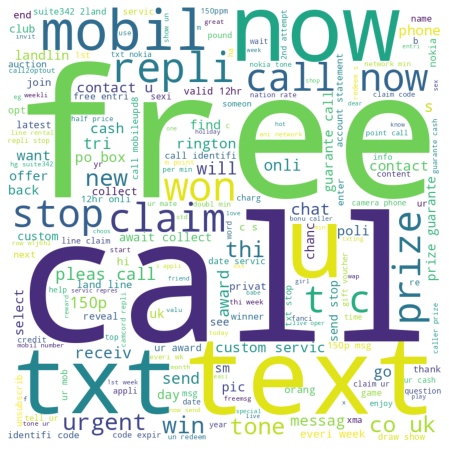

In [104]:
# Show word cloud for spam tokens
# TODO: try with ham tokens
one_big_string_of_tokens = ' '.join(spam_tokens)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(one_big_string_of_tokens)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off");

In [105]:
# Make a vocabulary for typical spam and ham keywords
spam_keywords = ['claim', 'win', 'repli', 'urgent', 'call', 'free', 'prize', 'now', 'txt', '$', 'click', 'here',
                'onlin', 'select']
ham_keywords = ['go', 'love', 'come', 'will', 'thanks', 'hope', 'time', 'friend', 'tonight', 'tomorrow', 
                'ok', 'meet', 'darl']
ham_spam_vocabulary = sorted(spam_keywords + ham_keywords)

## The Data exploration / preparation phase usually consists of a few iterations, where each time you visualize the results and come up with new ideas based on what you see in the results

- TODO: add more punctuation
- TODO: add more stopwords
- TODO: add more spam / ham keywords

# Convert text to vectors
To let a classifier learn the difference between spam and ham messages we need to convert the text to vectors. We do this by making a vocabulary for typical spam and ham keywords. We then count the number of occurences in each message. This technique is called Bag of Words. Because you take all the words, put them in a bag and count the frequencies. We limit our bag to a predefined vocabulary.

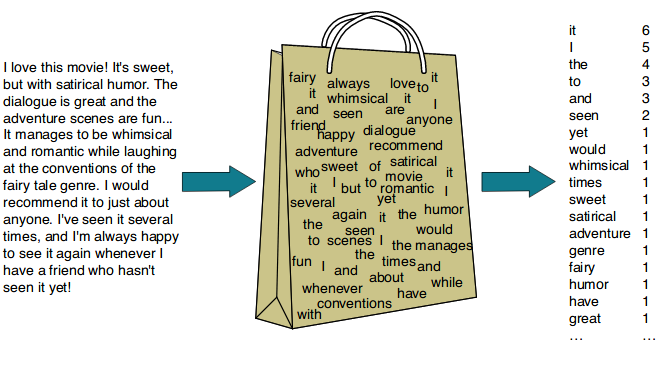

In [106]:
def transform_text_to_vector(tokens, vocabulary):
    # Store the frequency of the vocabulary words per message in a sorted (alphabetical) list => vector
    word_frequencies = []
    for vocabulary_word in vocabulary:
        word_frequencies.append(tokens.count(vocabulary_word))
    return np.array(word_frequencies)

In [113]:
# Example message
example_message = data['Message'].loc[8]
example_message

'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

In [108]:
# vocabulary
print(ham_spam_vocabulary)

['$', 'call', 'claim', 'click', 'come', 'darl', 'free', 'friend', 'go', 'here', 'hope', 'love', 'meet', 'now', 'ok', 'onlin', 'prize', 'repli', 'select', 'thanks', 'time', 'tomorrow', 'tonight', 'txt', 'urgent', 'will', 'win']


In [109]:
# The vector of the message containing the counts for typical ham/spam keywords
example_vector_custom = transform_text_to_vector(data['stemmed_tokens'].iloc[8], ham_spam_vocabulary)
example_vector_custom

array([0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0])

In [78]:
# Make vectors out of all messages
vectors = data['stemmed_tokens'].apply(transform_text_to_vector, args=(ham_spam_vocabulary,))

# Data modelling

In [29]:
# Transform labels to numbers
mapping = {'ham': 0,
          "spam": 1}

data['labels'] = data['Category'].map(mapping)

In [30]:
X = list(vectors)
y = data['labels']

In [31]:
# Split the data in train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [32]:
print(len(X_train), len(X_val), len(X_test))

3342 1115 1115


In [33]:
# make sure that the all sets contain enough spam and ham labels
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(0    2865
 1     477
 Name: labels, dtype: int64,
 0    992
 1    123
 Name: labels, dtype: int64,
 0    968
 1    147
 Name: labels, dtype: int64)

## TOTHINK: What happens if the train data does not contain any or a few spam messages? 
You could try it out by only including a few spam labels in the trainset! 
And play around with the nr of spam labels in the val set

In [34]:
# Initialize a classifier
clf = LogisticRegression()

# Fit the model on the train data
clf.fit(X_train, y_train)

LogisticRegression()

In [35]:
# Predict the validation set!
predictions = clf.predict(X_val)

## And that's it! We have trained a classifier on our spam / ham messages. Let's evaluate how good it is.

# Evaluation 
dummy data

In [36]:
# For each predictions was it a correct one? 6/7 are correct
y_true = np.array([0, 1, 0, 1, 0, 1, 1])
y_pred = np.array([0, 1, 0, 1, 0, 0, 1])
accuracy_score(y_true, y_pred)

0.8571428571428571

In [37]:
# Precision: how many retrieved items are relevant?

# Out of all "positive" predicted items? How many are truly positive?
# The 3 positive predictions are truly positive
y_true = np.array([0, 1, 0, 1, 0, 1, 1])
y_pred = np.array([0, 1, 0, 1, 0, 0, 1])
precision_score(y_true, y_pred)

1.0

In [38]:
# Recall: How many relevant items are retrieved?

# Out of all items that were truly "positive"? How many did "positive"  did we predict? 
# 3 out of 4 predictions are positive
y_true = np.array([0, 1, 0, 1, 0, 1, 1])
y_pred = np.array([0, 1, 0, 1, 0, 0, 1])
recall_score(y_true, y_pred)

0.75

In [39]:
# Weighted average of precision and recall
y_true = np.array([0, 1, 0, 1, 0, 1, 1])
y_pred = np.array([0, 1, 0, 1, 0, 0, 1])
f1_score(y_true, y_pred)

0.8571428571428571

# Evaluation 
Ham / Spam data

In [40]:
y_true = y_val.copy()
y_pred = clf.predict(X_val)

In [41]:
print('accuracy: ', accuracy_score(y_true, y_pred))
print('precision: ', precision_score(y_true, y_pred))
print('recall: ', recall_score(y_true, y_pred))
print('f1 score: ', f1_score(y_true, y_pred))

accuracy:  0.9443946188340807
precision:  0.8674698795180723
recall:  0.5853658536585366
f1 score:  0.6990291262135921


In [42]:
confusion_matrix(y_true, y_pred)

array([[981,  11],
       [ 51,  72]])

## These results are not bad at all for a first iteration! 

# Error analysis

In [152]:
# Make a new dataframe with categories, true labels and predicted labels
predictions_df = pd.DataFrame(data['Category'].loc[y_true.index])
predictions_df['y_true'] = y_true
predictions_df['y_pred'] = y_pred
predictions_df['message'] = data.loc[y_true.index, 'Message']

In [153]:
# Explore the incorrect predictions
predictions_df[predictions_df['y_true'] != predictions_df['y_pred']]

,Category,y_true,y_pred,message
3738,ham,0,1,plz note: if anyone calling from a mobile co. ...
5041,spam,1,0,natalie (20/f) is inviting you to be her frien...
3768,ham,0,1,"sir goodmorning, once free call me."
3568,spam,1,0,collect your valentine's weekend to paris inc ...
3720,spam,1,0,"thanks for your ringtone order, reference numb..."
...,...,...,...,...
3303,ham,0,1,stop calling everyone saying i might have canc...
3222,spam,1,0,"thanks for your ringtone order, reference numb..."
5365,spam,1,0,camera - you are awarded a sipix digital camer...
474,spam,1,0,want 2 get laid tonight? want real dogging loc...


## I think we can push the scores way higher! 
You can play around and do many many iterations with the validation set

### If you're satisfied with the results, you can use the model with "unseen" messages -> the test set!

# THE SHORT WAY
with Bag of Word model -> CountVectorizer

In [120]:
# Load data
data = pd.read_csv('spam.csv')

# Initialize the Bag of Words model
# This model does lowercasing, tokenization, stemming and optionally removal of stopwords! 
cv = CountVectorizer(stop_words='english')

# vectorize the sentences
X = cv.fit_transform(data['Message']).toarray()
# convert labels to numbers
y = data['Category'].map(mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a classifier
clf = LogisticRegression()

# Fit the model on the train data
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate!
print('accuracy: ', accuracy_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred))

accuracy:  0.9829596412556054
precision:  0.9923076923076923
recall:  0.8775510204081632
f1 score:  0.9314079422382673


In [112]:
# Remember the example message and the custom made vector?
print(example_message)
print(example_vector_custom)

winner!! as a valued network customer you have been selected to receivea £900 prize reward! to claim call 09061701461. claim code kl341. valid 12 hours only.
[0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]


In [121]:
# this is how it looks like with a Bag of Words vectorizer: with a vocabulary of 8440 words!
example_vector_bow = X[8]
print(example_vector_bow.shape)
example_vector_bow

(8440,)


array([0, 0, 0, ..., 0, 0, 0])

### Amazing! 93% F1 Score!
Without any modifications, just an "off the shelf" vectorizer + model, with default parameters.

In [155]:
confusion_matrix(y_test, y_pred)

array([[967,   1],
       [ 18, 129]])

In [157]:
predictions_df = pd.DataFrame(data['Category'].loc[y_test.index])
predictions_df['y_true'] = y_test
predictions_df['y_pred'] = y_pred
predictions_df['message'] = data.loc[y_test.index, 'Message']

In [158]:
predictions_df[predictions_df['y_true'] != predictions_df['y_pred']]

,Category,y_true,y_pred,message
1777,spam,1,0,Call FREEPHONE 0800 542 0578 now!
1217,spam,1,0,You have 1 new voicemail. Please call 08719181...
763,spam,1,0,Urgent Ur £500 guaranteed award is still uncla...
3780,spam,1,0,"Claim a 200 shopping spree, just call 08717895..."
3132,spam,1,0,LookAtMe!: Thanks for your purchase of a video...
2295,spam,1,0,You have 1 new message. Please call 08718738034.
5110,spam,1,0,You have 1 new message. Please call 08715205273
1045,spam,1,0,We know someone who you know that fancies you....
5,spam,1,0,FreeMsg Hey there darling it's been 3 week's n...
4073,spam,1,0,Loans for any purpose even if you have Bad Cre...


# THE SHORT WAY 2.0
with TF-IDF model -> TfidfVectorizer

In [122]:
# Load data
data = pd.read_csv('spam.csv')

# Initialize the TF-IDF model
# This model does lowercasing, tokenization, stemming and optionally removal of stopwords! 
cv = TfidfVectorizer(stop_words='english')

# vectorize the sentences
X = cv.fit_transform(data['Message']).toarray()
# convert labels to numbers
y = data['Category'].map(mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a classifier
clf = LogisticRegression()

# Fit the model on the train data
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate!
print('accuracy: ', accuracy_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred))

accuracy:  0.9614349775784753
precision:  0.9905660377358491
recall:  0.7142857142857143
f1 score:  0.8300395256916997


In [123]:
# And this is how it looks like with a TF-IDF vectorizer
example_vector_tfidf = X[8]
print(example_vector_tfidf.shape)
example_vector_tfidf

(8440,)


array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
confusion_matrix(y_test, y_pred)

array([[967,   1],
       [ 42, 105]])

In [46]:
predictions_df = pd.DataFrame(data['Category'].loc[y_test.index])
predictions_df['y_true'] = y_test
predictions_df['y_pred'] = y_pred
predictions_df['message'] = data.loc[y_test.index, 'Message']

In [47]:
predictions_df[predictions_df['y_true'] != predictions_df['y_pred']]

,Category,y_true,y_pred,message
1745,spam,1,0,Someone has conacted our dating service and en...
1777,spam,1,0,Call FREEPHONE 0800 542 0578 now!
2680,spam,1,0,"New Tones This week include: 1)McFly-All Ab..,..."
1217,spam,1,0,You have 1 new voicemail. Please call 08719181...
763,spam,1,0,Urgent Ur £500 guaranteed award is still uncla...
3780,spam,1,0,"Claim a 200 shopping spree, just call 08717895..."
4574,spam,1,0,URGENT! This is the 2nd attempt to contact U!U...
881,spam,1,0,Reminder: You have not downloaded the content ...
3132,spam,1,0,LookAtMe!: Thanks for your purchase of a video...
4419,ham,0,1,"When you get free, call me"


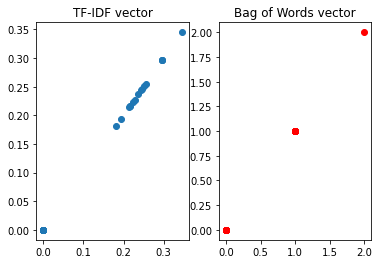

In [130]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(example_vector_tfidf, example_vector_tfidf)
ax[0].set_title('TF-IDF vector')

ax[1].scatter(example_vector_bow, example_vector_bow, color='r')
ax[1].set_title('Bag of Words vector');

## TOTHINK: what is the difference between these two vectorizers for the same sentence? 
While thinking about this, run the next line of code which downloads a Word2Vec model (~8 minutes)

# Pretrained word embeddings
A pretrained Word2Vec model, with 100 billion words

In [2]:
pretrained_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [165]:
pretrained_model.most_similar('lecture')

[('lectures', 0.8075485825538635),
 ('Lecture', 0.7942147254943848),
 ('Lectures', 0.718742847442627),
 ('colloquium', 0.6531552076339722),
 ('keynote_address', 0.650530219078064),
 ('Memorial_Lecture', 0.6435528993606567),
 ('seminar', 0.6332356333732605),
 ('Distinguished_Lecture', 0.6321801543235779),
 ('symposium', 0.6306586265563965),
 ('Lecture_Series', 0.6276640892028809)]

In [243]:
pretrained_model.most_similar('airplane')

[('plane', 0.8348401784896851),
 ('airplanes', 0.7777001261711121),
 ('aircraft', 0.76496422290802),
 ('planes', 0.7335887551307678),
 ('jet', 0.7161610722541809),
 ('airliner', 0.7074956297874451),
 ('jetliner', 0.7066361308097839),
 ('Cessna', 0.6621297001838684),
 ('propeller_plane', 0.6470087170600891),
 ('jumbo_jet', 0.6442608833312988)]

In [241]:
# Where we had a vector size of 8440 words in the Bag of Words / TF-IDF model, we now have a size of 300
pretrained_model['lecture'].shape

(300,)

In [237]:
pretrained_model['anunknownword']

KeyError: "Key 'anunknownword' not present"

In [232]:
def average_embeddings(tokens,model):
    embeddings = []
    # get embedding for each token in the sentence
    for token in tokens:
        try:
            embeddings.append(model[token])
        except KeyError:
            # if the word doesn't exist then use zeros with the size of the embedding
            embeddings.append(np.zeros(300))
    return np.mean(embeddings, axis=0)

In [239]:
# Load data
data = pd.read_csv('spam.csv')

# tokenize the sentences
data['tokens'] = data['Message'].apply(word_tokenize)

# get word embedding per token and average all embeddings in a sentence
X = data['tokens'].apply(average_embeddings, args=(pretrained_model,)).to_list()

# convert labels to numbers
y = data['Category'].map(mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a classifier
clf = LogisticRegression()

# Fit the model on the train data
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate!
print('accuracy: ', accuracy_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred))

accuracy:  0.9614349775784753
precision:  0.9193548387096774
recall:  0.7755102040816326
f1 score:  0.8413284132841327
